In [16]:
import face_alignment

from exchange_dialogues_params import *
from exchange_dialogues_functions import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import time

In [51]:
# config = MovieTranslationConfig()
# fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, enable_cuda=True, flip_input=False, use_cnn_face_detector=False)

# Transform 3D face pose and project 2D landmarks

1. Read 2 images
2. Read their landmarks
3. Plot the images and their landmarks
4. Transform the landmarks of one image to match the pose of the other image's face
5. Plot new landmarks

## 1. Read 2 images

In [6]:
im0 = cv2.cvtColor(cv2.imread('/shared/fusor/home/voleti.vikram/MOVIE_TRANSLATION/frames/telugu/Mahesh_Babu_2D_dlib/Mahesh_Babu_0000/Mahesh_Babu_0000_frame_025.png'), cv2.COLOR_BGR2RGB)

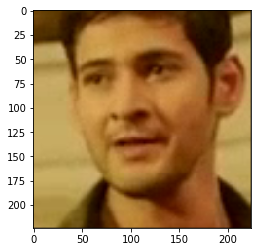

In [7]:
plt.imshow(im0)

In [8]:
im1 = cv2.cvtColor(cv2.imread('/shared/fusor/home/voleti.vikram/MOVIE_TRANSLATION/frames/telugu/Mahesh_Babu_2D_dlib/Mahesh_Babu_0000/Mahesh_Babu_0000_frame_035.png'), cv2.COLOR_BGR2RGB)

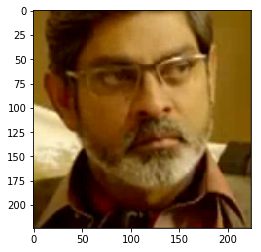

In [9]:
plt.imshow(im1)

## 2. Read their landmarks

In [72]:
# Read landmarks
telugu_Mahesh_Babu_landmarks = read_landmarks('telugu', 'Mahesh_Babu', 0)

# 3D landmarks
lm0 = np.array(telugu_Mahesh_Babu_landmarks[25][1:])
lm1 = np.array(telugu_Mahesh_Babu_landmarks[35][1:])

In [73]:
print(lm0.shape, lm1.shape)

(68, 3) (68, 3)


## 3. Plot the images and their landmarks

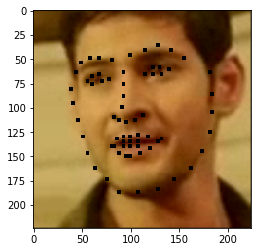

In [21]:
plot_lip_landmarks(lm0, im0)

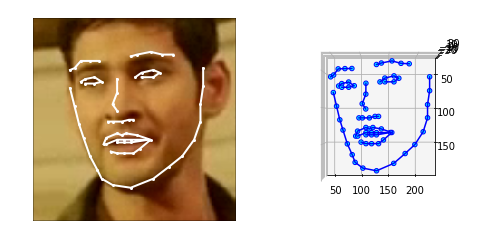

In [74]:
plot_3D_landmarks(im0, lm0)

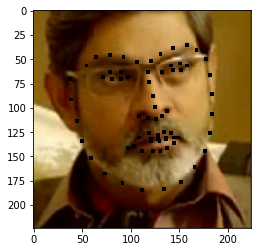

In [22]:
plot_lip_landmarks(lm1, im1)

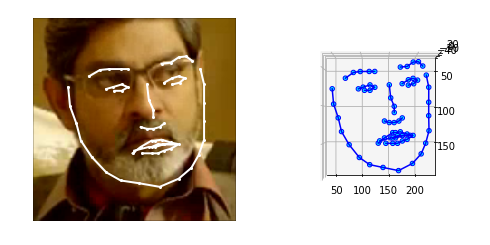

In [75]:
plot_3D_landmarks(im1, lm1)

# Using Homography

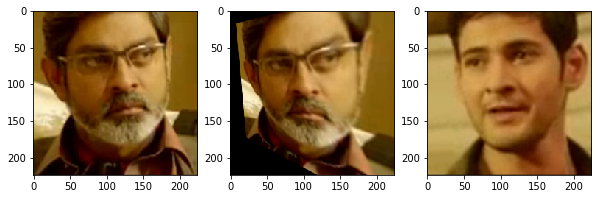

In [24]:
src_img = im1
src_points = lm1[:36, :2]
dst_img = im0
dst_points = lm0[:36, :2]
h, status = cv2.findHomography(src_points, dst_points)
warped_img_1_to_0 = cv2.warpPerspective(src_img, h, (224, 224))

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(src_img)
plt.subplot(132)
plt.imshow(warped_img_1_to_0)
plt.subplot(133)
plt.imshow(dst_img)

In [63]:
lm_w_1_to_0 = np.round(fa.get_landmarks(warped_img_1_to_0)[0]).astype('int')

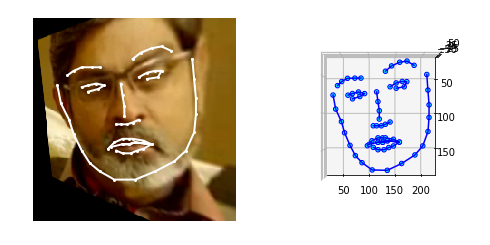

In [65]:
plot_3D_landmarks(warped_img_1_to_0, lm_w_1_to_0)

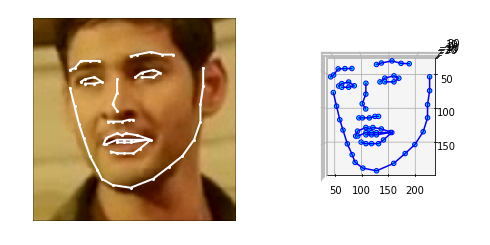

In [66]:
plot_3D_landmarks(im0, lm0)

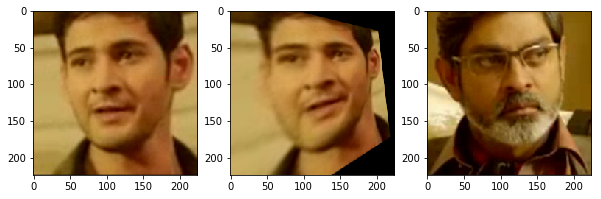

In [26]:
src_points = lm0[:36, :]
dst_points = lm1[:36, :]
src_img = im0
dst_img = im1
h, status = cv2.findHomography(src_points, dst_points)
warped_img_0_to_1 = cv2.warpPerspective(src_img, h, (224, 224))

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(src_img)
plt.subplot(132)
plt.imshow(warped_img_0_to_1)
plt.subplot(133)
plt.imshow(dst_img)

In [69]:
lm_w_0_to_1 = np.round(fa.get_landmarks(warped_img_0_to_1)[0]).astype('int')

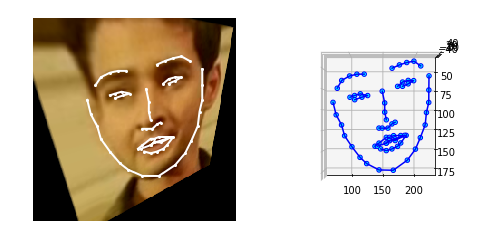

In [70]:
plot_3D_landmarks(warped_img_0_to_1, lm_w_0_to_1)

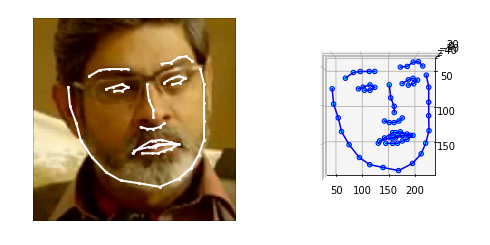

In [71]:
plot_3D_landmarks(im1, lm1)

# Find pose using a little help from [Satya Mallick](https://www.learnopencv.com/head-pose-estimation-using-opencv-and-dlib/), and his [other one](https://www.learnopencv.com/rotation-matrix-to-euler-angles/)

In [21]:
def get_R_t(landmarks, size):
    #2D image points. If you change the image, you need to change vector
#     image_points = np.array([
#                                 (359, 391),     # Nose tip
#                                 (399, 561),     # Chin
#                                 (337, 297),     # Left eye left corner
#                                 (513, 301),     # Right eye right corne
#                                 (345, 465),     # Left Mouth corner
#                                 (453, 469)      # Right mouth corner
#                             ], dtype="double")

    image_points = np.array([
                                landmarks[30],     # Nose tip
                                landmarks[8],     # Chin
                                landmarks[36],     # Left eye left corner
                                landmarks[45],     # Right eye right corne
                                landmarks[48],     # Left Mouth corner
                                landmarks[54]      # Right mouth corner
                            ], dtype="double")

    # 3D model points.
    model_points = np.array([
                                (0.0, 0.0, 0.0),             # Nose tip
                                (0.0, -330.0, -65.0),        # Chin
                                (-225.0, 170.0, -135.0),     # Left eye left corner
                                (225.0, 170.0, -135.0),      # Right eye right corne
                                (-150.0, -150.0, -125.0),    # Left Mouth corner
                                (150.0, -150.0, -125.0)      # Right mouth corner

                            ])


    # Camera internals

    focal_length = size[1]
    center = (size[1]/2, size[0]/2)
    camera_matrix = np.array(
                             [[focal_length, 0, center[0]],
                             [0, focal_length, center[1]],
                             [0, 0, 1]], dtype = "double"
                             )

#     print "Camera Matrix :\n {0}".format(camera_matrix)

    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)
 
    return rotation_vector, translation_vector

In [22]:
# Checks if a matrix is a valid rotation matrix.
def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6


# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R) :

    assert(isRotationMatrix(R))
    
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    
    singular = sy < 1e-6

    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0

    return np.array([x, y, z])

### Rotation matrix of im0

In [54]:
R0, t0 = get_R_t(lm0[:, :2], im0.shape)

In [55]:
R0

array([[-3.12884182],
       [ 0.22392992],
       [ 0.50855835]])

In [56]:
t0

array([[-91.53693078],
       [-35.87277376],
       [914.75598239]])

In [57]:
R00 = cv2.Rodrigues(R0)[0]

In [58]:
R00

array([[ 0.93886672, -0.13292345, -0.31758565],
       [-0.14451051, -0.98941659, -0.01309706],
       [-0.3124836 ,  0.05819085, -0.94813914]])

In [59]:
lm0_R = np.dot(R00, lm0.T).T

ValueError: shapes (3,3) and (2,68) not aligned: 3 (dim 1) != 2 (dim 0)

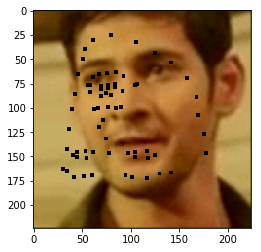

In [60]:
plot_lip_landmarks(lm0_R[:, :2], im0)

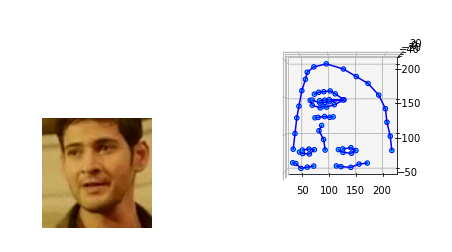

In [31]:
plot_3D_landmarks(im0, lm0_R)

WHY??????

In [32]:
lm0_RT = np.dot(R00.T, lm0.T).T

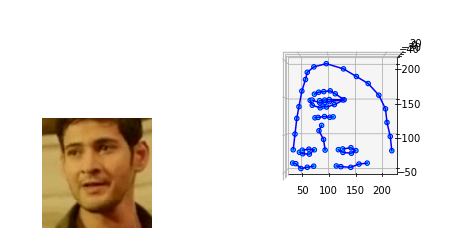

In [33]:
plot_3D_landmarks(im0, lm0_RT)

## Transform landmark points using projection matrix

In [40]:
def deg_to_rad(d):
    r = (d * np.pi / 180) % (2 * np.pi)
    if r > np.pi:
        return -(2*np.pi - r)
    else:
        return r

In [41]:
def rotation_matrix_3D(a, b, c):
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(a), -np.sin(a)],
        [0, np.sin(a), np.cos(a)]
    ])
    Ry = np.array([
        [np.cos(b), 0, np.sin(b)],
        [0, 1, 0],
        [-np.sin(b), 0, np.cos(b)]
    ])
    Rz = np.array([
        [np.cos(c), -np.sin(c), 0],
        [np.sin(c), np.cos(c), 0],
        [0, 0, 1]
    ])
    R = np.dot(Rz, np.dot(Ry, Rx))
    return R

### Rotation matrix of im0

In [76]:
R1, t1 = get_R_t(lm1[:, :2], im1.shape)

In [77]:
R1

array([[-3.1403452 ],
       [ 0.21167409],
       [-0.09858637]])

In [78]:
t1

array([[ 88.87423687],
       [ -9.13873827],
       [939.9690162 ]])

In [79]:
cv2.Rodrigues(R1)[0]

array([[ 0.98900306, -0.1342987 ,  0.06194197],
       [-0.13383398, -0.99093575, -0.01161029],
       [ 0.06293976,  0.00319267, -0.99801222]])

In [80]:
rotationMatrixToEulerAngles(cv2.Rodrigues(R1)[0])

array([ 3.13839364, -0.06298139, -0.13450506])

In [81]:
rotation_matrix_3D(3.13839364, -0.06298139, -0.13450506)

array([[ 0.98900306, -0.1342987 ,  0.06194197],
       [-0.13383398, -0.99093575, -0.01161028],
       [ 0.06293976,  0.00319267, -0.99801222]])

In [88]:
RR = rotation_matrix_3D(-0.2139631 , -3.1338608 , -0.13682924)

In [70]:
lm1_RR = np.dot(RR, np.hstack((lm1, np.zeros((68, 1)))).T).T

In [89]:
lm1_RR = np.dot(RR, lm1.T).T

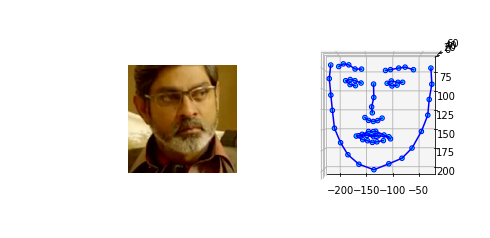

In [90]:
plot_3D_landmarks(im1, lm1_RR)

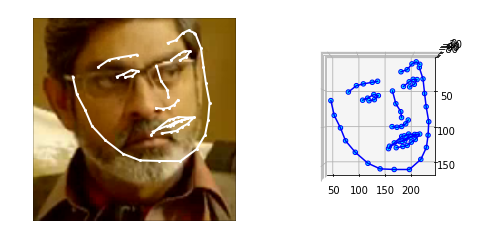

In [100]:
RRT = rotation_matrix_3D(2.96482592, 0.04430636, 0.14867311)
lm1_RRT = np.dot(RRT, lm1.T).T
plot_3D_landmarks(im1, lm1_RRT)

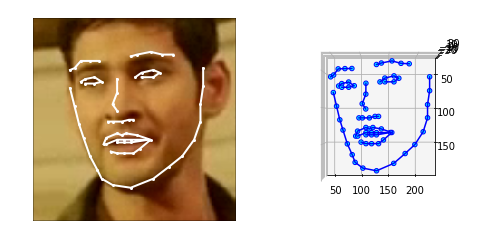

In [112]:
plot_3D_landmarks(im0, lm0)

In [91]:
rotationMatrixToEulerAngles(cv2.Rodrigues(R0)[0])

array([ 3.08029579,  0.31780644, -0.15272161])

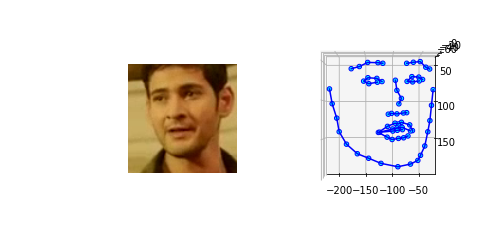

In [93]:
RR0 = rotation_matrix_3D(0.31780644, 3.08029579,  -0.15272161)
lm0_RR = np.dot(RR0, lm0.T).T
plot_3D_landmarks(im0, lm0_RR)

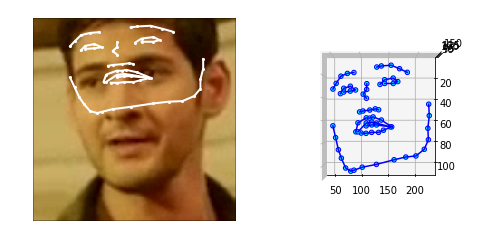

In [94]:
RRz0 = rotation_matrix_3D(1, 0, 0)
lm0_RRz0 = np.dot(RRz0, lm0.T).T
plot_3D_landmarks(im0, lm0_RRz0)

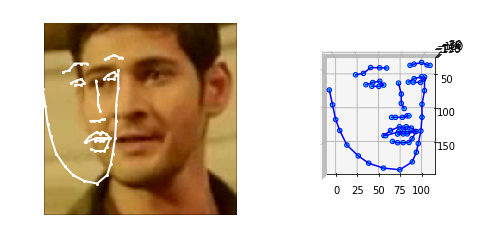

In [95]:
RRz0 = rotation_matrix_3D(0, 1, 0)
lm0_RRz0 = np.dot(RRz0, lm0.T).T
plot_3D_landmarks(im0, lm0_RRz0)

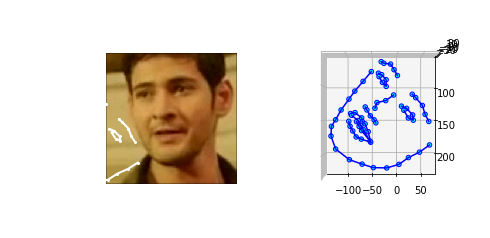

In [96]:
RRz0 = rotation_matrix_3D(0, 0, 1)
lm0_RRz0 = np.dot(RRz0, lm0.T).T
plot_3D_landmarks(im0, lm0_RRz0)

In [114]:
angles0

array([ 3.13588163,  0.21991781, -0.12210361])

[ 3.13588163  0.21991781 -0.12210361]


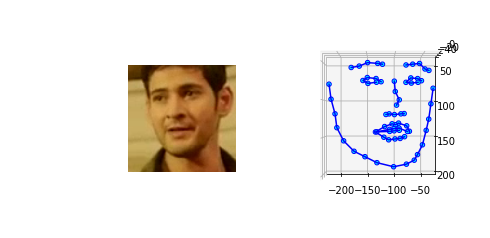

In [133]:
R0, t0 = get_R_t(lm0[:, :2], im0.shape)
angles0 = rotationMatrixToEulerAngles(cv2.Rodrigues(R0)[0])
print(angles0)
RR0 = rotation_matrix_3D(angles0[1], -angles0[0], angles0[2])
lm0_RR0 = np.dot(RR0, lm0.T).T
plot_3D_landmarks(im0, lm0_RR0)

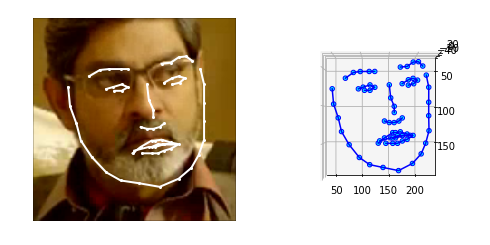

In [113]:
plot_3D_landmarks(im1, lm1)

[ 3.13839364 -0.06298139 -0.13450506]


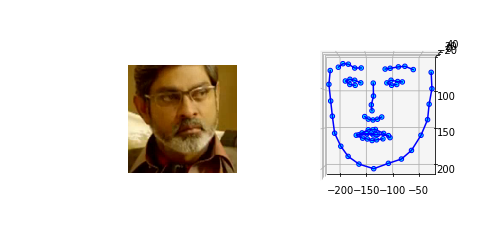

In [132]:
R1, t1 = get_R_t(lm1[:, :2], im1.shape)
angles1 = rotationMatrixToEulerAngles(cv2.Rodrigues(R1)[0])
print(angles1)
RR1 = rotation_matrix_3D(angles1[1], angles1[0], angles1[2])
lm1_RR1 = np.dot(RR1, lm1.T).T
plot_3D_landmarks(im1, lm1_RR1)

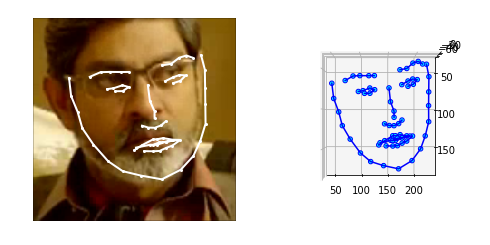

In [127]:
RR_1_0 = rotation_matrix_3D(angles1[1]-angles0[1], -angles1[0]+angles0[0], angles1[2]-angles0[2])
lm1_RR1_0 = np.dot(RR_1_0, lm1.T).T
plot_3D_landmarks(im1, lm1_RR1_0)

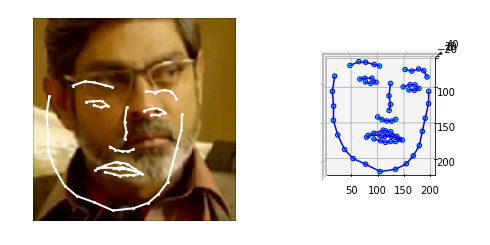

In [126]:
RR_1_0 = np.dot(rotation_matrix_3D(-angles0[1], angles0[0], -angles0[2]), rotation_matrix_3D(angles1[1], -angles1[0], angles1[2]))
lm1_RR1_0 = np.dot(RR_1_0, lm1.T).T
plot_3D_landmarks(im1, lm1_RR1_0)

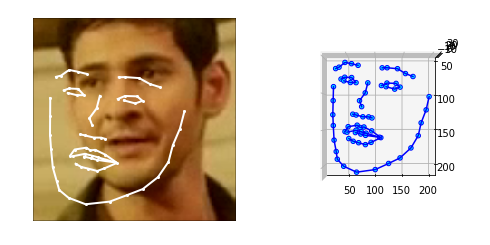

In [128]:
RR_0_1 = np.dot(rotation_matrix_3D(-angles1[1], angles1[0], -angles1[2]), rotation_matrix_3D(angles0[1], -angles0[0], angles0[2]))
lm0_RR0_1 = np.dot(RR_0_1, lm0.T).T
plot_3D_landmarks(im0, lm0_RR0_1)

## 4. Find yaw, pitch, roll

-----------> x

|

|

v

y

$Pitch$ is rotation about $x$-axis.

$Yaw$ is rotation about $y$-axis.

$Roll$ is rotation about $z$-axis.

![alt text](yaw_pitch_roll.png "Title")

In [14]:
def find_yaw_pitch_roll(img_points, obj_points=None):
    if obj_points is None:
        obj_points = np.array([[-36.9522, 39.3518, 47.1217],
                            [35.446, 38.4345, 47.6468],
                            [-0.0697709, 18.6015, 87.9695],
                            [-27.6439, -29.6388, 73.8551],
                            [28.7793, -29.2935, 72.7329],
                            [-87.2155, 15.5829, -45.1352],
                            [85.8383, 14.9023, -46.3169]
                           ], dtype=np.float32)/35.
    w = 224
    h = 224
    ppa     = (w/2., h/2.)
    fm      = 7.5/1e3
    sensor  = (7.14e-3, 5.36e-3)
    focal   = w*(fm / sensor[0])
    cam_mat = np.array( [[focal, 0, ppa[0]],
                         [0, focal, ppa[1]],
                         [0, 0, 1]], dtype = np.float64
                      )
    dist_coeffs = np.zeros((5,1))
    rvecc = np.zeros((3,1))
    tvecc = np.zeros((3,1))
    flag = cv2.SOLVEPNP_ITERATIVE # tried with SOLVEPNP_EPNP, same error.
    retval, rotation_vector, translation_vector = cv2.solvePnP(obj_points, img_points, cam_mat, dist_coeffs, rvecc, tvecc, flags=flag)
    rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
    proj_matrix = np.hstack((rvec_matrix, translation_vector))
    eulerAngles = -cv2.decomposeProjectionMatrix(proj_matrix)[6] 
    yaw   = eulerAngles[1]
    pitch = eulerAngles[0]
    roll  = eulerAngles[2]
#     if pitch > 0:
#       pitch = 180 - pitch
#     elif pitch < 0:
#       pitch = -180 - pitch
#     yaw = -yaw
    ypr = yawpitchrolldecomposition(rvec_matrix)
    print(yaw, pitch, roll)
    print(ypr)
    return proj_matrix, yaw, pitch, roll, ypr

In [15]:
def yawpitchrolldecomposition(R):
    import math
    import numpy as np
    sin_x    = math.sqrt(R[2,0] * R[2,0] +  R[2,1] * R[2,1])    
    validity  = sin_x < 1e-6
    if R[2,1] != 0 and R[1, 2] != 0:
        z1    = math.atan2(R[2,0], R[2,1])     # around z1-axis
        x      = math.atan2(sin_x,  R[2,2])     # around x-axis
        z2    = math.atan2(R[0,2], -R[1,2])    # around z2-axis
    else: # gimbal lock
        z1    = 0                                         # around z1-axis
        x      = math.atan2(sin_x,  R[2,2])     # around x-axis
        z2    = 0                                         # around z2-axis

    return np.array([[z1], [x], [z2]])

# yawpitchroll_angles = -180*yawpitchrolldecomposition(rmat)/math.pi
# yawpitchroll_angles[0,0] = (360-yawpitchroll_angles[0,0])%360 # change rotation sense if needed, comment this line otherwise
# yawpitchroll_angles[1,0] = yawpitchroll_angles[1,0]+90

In [16]:
# Image points of im0
image_points_3D_0 = np.array([lm0[38],
                              lm0[44],
                              lm0[30],
                              lm0[48],
                              lm0[54],
                              lm0[00],
                              lm0[16]], dtype='float32')
image_points_0 = np.array(image_points_3D_0[:, :2])

In [17]:
# Image points of im0
image_points_3D_1 = np.array([lm1[38],
                              lm1[44],
                              lm1[30],
                              lm1[48],
                              lm1[54],
                              lm1[00],
                              lm1[16]], dtype='float32')
image_points_1 = np.array(image_points_3D_1[:, :2])

In [20]:
pm, y, p, r, ypr = find_yaw_pitch_roll(image_points_0, obj_points=image_points_3D_1)

[25.29999024] [-0.09336701] [176.20110076]
[[1.56734898]
 [0.44157094]
 [1.64091272]]


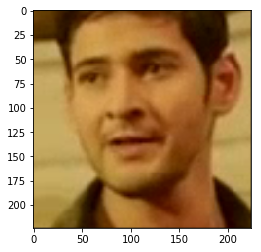

In [12]:
plt.imshow(im0)

In [16]:
proj_0, y_0, p_0, r_0, ypr = find_yaw_pitch_roll(image_points_0)

[-9.56826271] [156.34087584] [5.04331381]
[[-2.74391389]
 [ 2.69797926]
 [-2.86699182]]


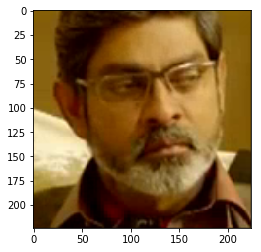

In [17]:
plt.imshow(im1)

In [18]:
proj_1, y_1, p_1, r_1, ypr_1 = find_yaw_pitch_roll(image_points_1)

[4.48701588] [150.8325035] [8.03935222]
[[2.98194645]
 [2.6270592 ]
 [2.86201834]]


In [8]:
ypr0 = [-0.0206073, -0.0520677, 0.544732]
ypr1 = [0.00631391, -0.0530485, 0.53071]

In [19]:
print(proj_1.shape, lm1.shape)

(3, 4) (68, 3)


In [20]:
lm1_proj = np.dot(proj_1, np.hstack((lm1, np.ones(len(lm1)).reshape(-1, 1))).T).T

In [21]:
proj_1

array([[ 0.98713746, -0.08436629,  0.13580122,  0.28299112],
       [-0.13942457, -0.86994945,  0.47302087, -0.81172879],
       [ 0.07823318, -0.48587065, -0.87052242,  7.9760113 ]])

In [22]:
lm1[0]

array([ 38,  76, -23])

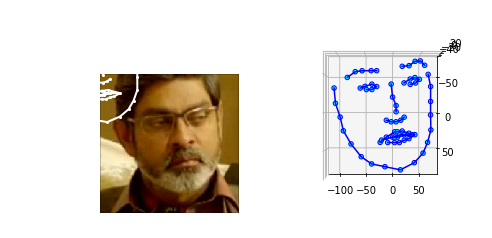

In [23]:
plot_3D_landmarks(im1, lm1-np.mean(lm1, axis=0))

![alt text](yaw_pitch_roll.png "Title")

In [ ]:
ypr

#### YAW - rotation about Y-axis

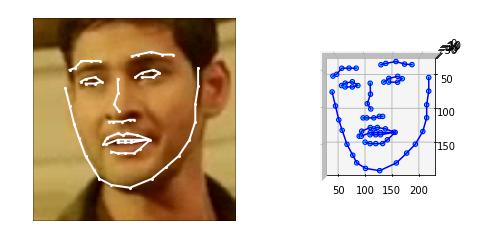

In [82]:
neg_yaw_angle = 9.56826271*np.pi/180
lm0_proj_yaw = np.dot(np.array([[ np.cos(neg_yaw_angle), 0, np.sin(neg_yaw_angle), 0], [0, 1, 0, 0], [-np.sin(neg_yaw_angle), 0, np.cos(neg_yaw_angle), 0], [0, 0, 0, 1]]), np.hstack((lm0, np.ones(len(lm0)).reshape(-1, 1))).T).T
# plot_3D_landmarks(im0, lm0_proj_yaw[:, :3])
plot_3D_landmarks(im0, lm0_proj_yaw)

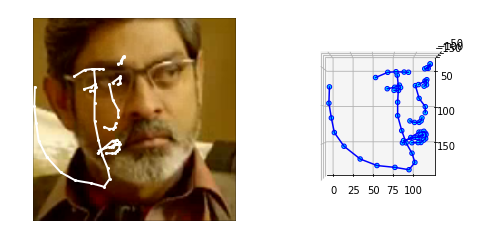

In [86]:
neg_yaw_angle = 1
lm1_proj_yaw = np.dot(np.array([[ np.cos(neg_yaw_angle), 0, np.sin(neg_yaw_angle), 0], [0, 1, 0, 0], [-np.sin(neg_yaw_angle), 0, np.cos(neg_yaw_angle), 0], [0, 0, 0, 1]]), np.hstack((lm1, np.ones(len(lm1)).reshape(-1, 1))).T).T
# plot_3D_landmarks(im1, lm1_proj_yaw[:, :3])
plot_3D_landmarks(im1, lm1_proj_yaw)

#### ROLL - rotation about Z-axis

In [73]:
neg_roll_angle = -0.123963755
lm0_proj_yaw_done = lm0_proj_yaw[:, :3]
lm0_proj_yaw_roll = np.dot(np.array([[np.cos(neg_roll_angle), np.sin(neg_roll_angle), 0, 0], [-np.sin(neg_roll_angle), np.cos(neg_roll_angle), 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]), np.hstack((lm0_proj_yaw_done, np.ones(len(lm1_proj_yaw_done)).reshape(-1, 1))).T).T
plot_3D_landmarks(im0, lm0_proj_yaw_roll[:, :3])

NameError: name 'lm0_proj_yaw' is not defined

In [ ]:
neg_roll_angle = -0.123963755
lm1_proj_yaw_done = lm1_proj_yaw[:, :3]
lm1_proj_yaw_roll = np.dot(np.array([[np.cos(neg_roll_angle), np.sin(neg_roll_angle), 0, 0], [-np.sin(neg_roll_angle), np.cos(neg_roll_angle), 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]), np.hstack((lm1_proj_yaw_done, np.ones(len(lm1_proj_yaw_done)).reshape(-1, 1))).T).T
plot_3D_landmarks(im1, lm1_proj_yaw_roll[:, :3])

#### PITCH - rotation about X-axis

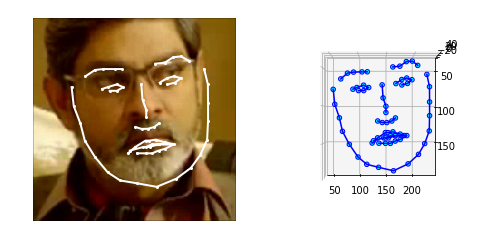

In [56]:
neg_pitch_angle = 0
lm1_proj_yaw_done = lm1_proj_yaw[:, :3]
lm1_proj_yaw_pitch = np.dot(np.array([[ 1, 0, 0, 0], [0, np.cos(neg_pitch_angle), -np.sin(neg_pitch_angle), 0], [0, np.sin(neg_pitch_angle), np.cos(neg_pitch_angle), 0], [0, 0, 0, 1]]), np.hstack((lm1_proj_yaw_done, np.ones(len(lm1_proj_yaw_done)).reshape(-1, 1))).T).T
plot_3D_landmarks(im1, lm1_proj_yaw_pitch[:, :3])

# CHECKING FACE POSE VALUES

In [ ]:
face_poses_0 = cv2.imread('/home/voletiv/Downloads/face_poses/face_poses_0.png')

## YAW

In [ ]:
# Yaw
plt.imshow(face_poses_0[:face_poses_0.shape[0]//3, :])

In [ ]:
# Split the image into the respective yaw faces
def get_breaking_points(face_poses_0):
    whites = []
    for i in range(face_poses_0.shape[1]):
        if np.all(face_poses_0[:face_poses_0.shape[0]//3, i] == 255):
                whites.append(i)

    break_points = []
    whites_range = []
    prev_whites_i = whites[0] - 1
    for i in range(len(whites)):
        if whites[i] - prev_whites_i == 1:
            whites_range.append(whites[i])
            prev_whites_i = whites[i]
        else:
            break_points.append(int(np.round(np.mean(whites_range))))
            whites_range = []
            whites_range.append(whites[i])
            prev_whites_i = whites[i]

    break_points.append(int(np.round(np.mean(whites_range))))
    
    return break_points

In [ ]:
# yaw_break_points = get_breaking_points(face_poses_0[:face_poses_0.shape[0]//3, :])
yaw_break_points = [8, 97, 174, 251, 322, 390, 466, 536, 605, 675, 748, 836]

In [ ]:
fig = plt.figure()
plt.ion()
fig.canvas.draw()
for b in range(len(yaw_break_points) - 1):
    plt.imshow(face_poses_0[:face_poses_0.shape[0]//3, yaw_break_points[b]:yaw_break_points[b+1]])
    time.sleep(.5)
    fig.canvas.draw()

In [ ]:
yaw_images_list = []
for b in range(len(yaw_break_points) - 1):
    yaw_images_list.append(face_poses_0[:face_poses_0.shape[0]//3, yaw_break_points[b]:yaw_break_points[b+1]])
#     cv2.imwrite(os.path.join('/home/voletiv/Downloads/face_poses/', 'face_poses_0_yaw_%02d.png' % b), face_poses_0[:face_poses_0.shape[0]//3, yaw_break_points[b]:yaw_break_points[b+1]])

## PITCH

In [ ]:
# pitch_break_points = get_breaking_points(face_poses_0[face_poses_0.shape[0]//3:2*face_poses_0.shape[0]//3, :])
pitch_break_points = [18, 106, 177, 248, 319, 393, 464, 532, 605, 671, 745, 830]
print(pitch_break_points)

In [ ]:
fig = plt.figure()
plt.ion()
fig.canvas.draw()
for b in range(len(pitch_break_points) - 1):
    plt.imshow(face_poses_0[face_poses_0.shape[0]//3:2*face_poses_0.shape[0]//3, pitch_break_points[b]:pitch_break_points[b+1]])
    time.sleep(.5)
    fig.canvas.draw()

In [ ]:
pitch_images_list = []
for b in range(len(pitch_break_points) - 1):
    pitch_images_list.append(face_poses_0[face_poses_0.shape[0]//3:2*face_poses_0.shape[0]//3, pitch_break_points[b]:pitch_break_points[b+1]])
#     cv2.imwrite(os.path.join('/home/voletiv/Downloads/face_poses/', 'face_poses_0_pitch_%02d.png' % b), face_poses_0[face_poses_0.shape[0]//3:2*face_poses_0.shape[0]//3, pitch_break_points[b]:pitch_break_points[b+1]] )

## ROLL

In [ ]:
# roll_break_points = get_breaking_points(face_poses_0[2*face_poses_0.shape[0]//3:, :])
roll_break_points = [2, 100, 171, 270, 334, 398, 464, 532, 606, 680, 768, 849]
print(roll_break_points)

In [ ]:
fig = plt.figure()
plt.ion()
fig.canvas.draw()
for b in range(len(roll_break_points) - 1):
    plt.imshow(face_poses_0[2*face_poses_0.shape[0]//3:, roll_break_points[b]:roll_break_points[b+1]])
    time.sleep(.5)
    fig.canvas.draw()

In [ ]:
roll_images_list = []
for b in range(len(roll_break_points) - 1):
    roll_images_list.append(face_poses_0[face_poses_0.shape[0]//3:2*face_poses_0.shape[0]//3, roll_break_points[b]:roll_break_points[b+1]])
#     cv2.imwrite(os.path.join('/home/voletiv/Downloads/face_poses/', 'face_poses_0_roll_%02d.png' % b), face_poses_0[face_poses_0.shape[0]//3:2*face_poses_0.shape[0]//3, roll_break_points[b]:roll_break_points[b+1]] )

## Check yaw

In [ ]:
yaw_ypr0 = []
yaw_ypr1 = []
yaw_lms = []
for y, yaw_image in enumerate(yaw_images_list):
    print(y)
    lm = fa.get_landmarks(yaw_image)[0]
    yaw_lms.append(lm)
    image_points = np.array([lm[38],
                             lm[44],
                             lm[30],
                             lm[48],
                             lm[54],
                             lm[00],
                             lm[16]], dtype='float32')
    image_points = np.array(image_points[:, :2])
    proj_1, y_1, p_1, r_1, ypr_1 = find_yaw_pitch_roll(image_points)
    yaw_ypr0.append([y_1, p_1, r_1])
    yaw_ypr1.append([ypr_1])

In [ ]:
fig = plt.figure()
plt.ion()
fig.canvas.draw()
for landmarks, image in zip(yaw_lms, yaw_images_list):
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(image)
    ax.plot(landmarks[0:17, 0], landmarks[0:17, 1], marker='o', markersize=2, linestyle='-', color='w', lw=2)
    ax.plot(landmarks[17:22, 0], landmarks[17:22, 1], marker='o', markersize=2, linestyle='-', color='w', lw=2)
    ax.plot(landmarks[22:27, 0], landmarks[22:27, 1], marker='o', markersize=2, linestyle='-', color='w', lw=2)
    ax.plot(landmarks[27:31, 0], landmarks[27:31, 1], marker='o', markersize=2, linestyle='-', color='w', lw=2)
    ax.plot(landmarks[31:36, 0], landmarks[31:36, 1], marker='o', markersize=2, linestyle='-', color='w', lw=2)
    ax.plot(landmarks[36:42, 0], landmarks[36:42, 1], marker='o', markersize=2, linestyle='-', color='w', lw=2)
    ax.plot(landmarks[42:48, 0], landmarks[42:48, 1], marker='o', markersize=2, linestyle='-', color='w', lw=2)
    ax.plot(landmarks[48:60, 0], landmarks[48:60, 1], marker='o', markersize=2, linestyle='-', color='w', lw=2)
    ax.plot(landmarks[60:68, 0], landmarks[60:68, 1], marker='o', markersize=2, linestyle='-', color='w', lw=2)
    ax.axis('off')
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.scatter(landmarks[:, 0]*1.2, landmarks[:,1], landmarks[:, 2], c="cyan", alpha=1.0, edgecolor='b')
    ax.plot3D(landmarks[:17, 0]*1.2, landmarks[:17,1], landmarks[:17,2], color='blue' )
    ax.plot3D(landmarks[17:22, 0]*1.2, landmarks[17:22, 1], landmarks[17:22, 2], color='blue')
    ax.plot3D(landmarks[22:27, 0]*1.2, landmarks[22:27, 1], landmarks[22:27, 2], color='blue')
    ax.plot3D(landmarks[27:31, 0]*1.2, landmarks[27:31, 1], landmarks[27:31, 2], color='blue')
    ax.plot3D(landmarks[31:36, 0]*1.2, landmarks[31:36, 1], landmarks[31:36, 2], color='blue')
    ax.plot3D(landmarks[36:42, 0]*1.2, landmarks[36:42, 1], landmarks[36:42, 2], color='blue')
    ax.plot3D(landmarks[42:48, 0]*1.2, landmarks[42:48, 1], landmarks[42:48, 2], color='blue')
    ax.plot3D(landmarks[48:60, 0]*1.2, landmarks[48:60, 1], landmarks[48:60, 2], color='blue' )
    ax.plot3D(landmarks[60:, 0]*1.2, landmarks[60:, 1], landmarks[60:, 2], color='blue' )
    ax.view_init(elev=90., azim=90.)
    ax.set_xlim(ax.get_xlim()[::-1])
    fig.canvas.draw()
    time.sleep(.5)

In [ ]:
yaw_ypr0 = np.array(yaw_ypr0).reshape(-1, 3)
print(yaw_ypr0)

In [ ]:
yaw_ypr1 = np.array(yaw_ypr1).reshape(-1, 3)
print(yaw_ypr1)

## Check Pitch

In [ ]:
pitch_ypr0 = []
pitch_ypr1 = []
pitch_lms = []
for p, pitch_image in enumerate(pitch_images_list):
    print(p)
    lm = fa.get_landmarks(pitch_image)
    if lm is not None:
        lm = lm[0]
        pitch_lms.append(lm)
        image_points = np.array([lm[38],
                                 lm[44],
                                 lm[30],
                                 lm[48],
                                 lm[54],
                                 lm[00],
                                 lm[16]], dtype='float32')
        image_points = np.array(image_points[:, :2])
        proj_1, y_1, p_1, r_1, ypr_1 = find_yaw_pitch_roll(image_points)
        pitch_ypr0.append([y_1, p_1, r_1])
        pitch_ypr1.append([ypr_1])

In [ ]:
pitch_ypr0 = np.array(pitch_ypr0).reshape(-1, 3)
print(pitch_ypr0)

In [ ]:
pitch_ypr1 = np.array(pitch_ypr1).reshape(-1, 3)
print(pitch_ypr1)

## Check Roll

In [ ]:
roll_ypr0 = []
roll_ypr1 = []
roll_lms = []
for p, roll_image in enumerate(roll_images_list):
    print(p)
    lm = fa.get_landmarks(roll_image)
    if lm is not None:
        lm = lm[0]
        roll_lms.append(lm)
        image_points = np.array([lm[38],
                                 lm[44],
                                 lm[30],
                                 lm[48],
                                 lm[54],
                                 lm[00],
                                 lm[16]], dtype='float32')
        image_points = np.array(image_points[:, :2])
        proj_1, y_1, p_1, r_1, ypr_1 = find_yaw_pitch_roll(image_points)
        roll_ypr0.append([y_1, p_1, r_1])
        roll_ypr1.append([ypr_1])

In [ ]:
roll_ypr0 = np.array(roll_ypr0).reshape(-1, 3)
print(roll_ypr0)

In [ ]:
roll_ypr1 = np.array(roll_ypr1).reshape(-1, 3)
print(roll_ypr1)

In [ ]:
np.round(roll_ypr0[:, 2])

In [ ]:
exp_proj_1 = np.vstack((proj_1, np.array([0, 0, 0, 1]).reshape(1, -1)))
rev_proj_1 = np.vstack((np.hstack((proj_1[:, :3].T, -proj_1[:, 3].reshape(-1, 1))), np.array([0, 0, 0, 1]).reshape(1, -1)))
print(rev_proj_1.shape)

In [ ]:
lm1_proj = np.dot(exp_proj_1, np.hstack((lm1, np.ones(len(lm1)).reshape(-1, 1))).T).T
plot_3D_landmarks(im1, lm1_proj[:, :3])

In [ ]:
lm1_proj.shape

In [ ]:
lm1_rev_proj = np.dot(rev_proj_1, np.hstack((lm1, np.ones(len(lm1)).reshape(-1, 1))).T).T
plot_3D_landmarks(im1, lm1_rev_proj)

In [ ]:
# Camera marix
camera_matrix = np.array([[20, 0, 160], [0, 20, 120], [0, 0, 1]], dtype='float64')
print(camera_matrix, camera_matrix.shape, type(camera_matrix[0][0]))

In [ ]:
# Distortion coefficients
distortion_coeffs = np.array([0, 0, 0, 0, 0]).astype('float32').reshape(-1, 1)
print(distortion_coeffs.shape, type(distortion_coeffs[0][0]))

In [ ]:
# Rotation vector
d = np.array([[1, 0, 0], [0, -1, 0,], [0, 0, -1]], dtype=('float32'))
rvec = cv2.Rodrigues(d)[0]
print(rvec, rvec.shape, type(rvec[0][0]))

In [ ]:
# Translation vector
tvec = np.array([0, 0, 1]).astype('float32').reshape(3, 1)
print(tvec, tvec.shape, type(tvec[0][0]))

In [ ]:
retval, rotation_vector, translation_vector = cv2.solvePnP(object_points, image_points_0_flip, camera_matrix, distortion_coeffs, rvec, tvec, flags=flag)
rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
proj_matrix = np.hstack((rvec_matrix, translation_vector))
eulerAngles = -cv2.decomposeProjectionMatrix(proj_matrix)[6] 
yaw   = eulerAngles[1]
pitch = eulerAngles[0]
roll  = eulerAngles[2]
if pitch > 0:
  pitch = 180 - pitch
elif pitch < 0:
  pitch = -180 - pitch
yaw = -yaw

print(yaw, pitch, roll)

In [ ]:
# obj_pts = np.array([[10,60,0],
#                     [10,60,12.6],
#                     [24,60,0],
#                     [24,60,12.6],
#                     [24,74,0],
#                     [24,74,12.6],
#                     [47.7,70,8.8]
#                    ], dtype=np.float32)

obj_pts = np.array([[-36.9522, 39.3518, 47.1217],
                    [35.446, 38.4345, 47.6468],
                    [-0.0697709, 18.6015, 87.9695],
                    [-27.6439, -29.6388, 73.8551],
                    [28.7793, -29.2935, 72.7329],
                    [-87.2155, 15.5829, -45.1352],
                    [85.8383, 14.9023, -46.3169]
                   ], dtype=np.float32)/35.

# img_pts = np.array([[96.,  72.],
#                     [160.,  64.],
#                     [133., 112.],
#                     [109., 148.],
#                     [159., 141.],
#                     [ 38.,  76.],
#                     [186.,  55.]
#                    ], dtype=np.float32)

# img_pts = np.array([[800,970],
#                     [689,329],
#                     [1380,1175],
#                     [1363,458],
#                     [1842,881],
#                     [1875,256],
#                     [3052,852]
#                    ], dtype=np.float32)

w = 224
h = 224
ppa     = (w/2., h/2.)
fm      = 7.5/1e3
sensor  = (7.14e-3, 5.36e-3)
focal   = w*(fm / sensor[0])

cam_mat = np.array( [[focal, 0, ppa[0]],
                     [0, focal, ppa[1]],
                     [0, 0, 1]], dtype = np.float64
                  )

# cam_mat = np.array( [[20, 0, 160],
#                      [0, 20, 120],
#                      [0, 0, 1]], dtype = np.float64
#                   )
  
dist_coeffs = np.zeros((5,1))

rvecc = np.zeros((3,1))
# d = np.array([[1, 0, 0], [0, -1, 0,], [0, 0, -1]], dtype=('float32'))
# rvecc = cv2.Rodrigues(d)[0]

tvecc = np.zeros((3,1)) 
# tvecc = np.array([0., 0., 1.])

flag = cv2.SOLVEPNP_ITERATIVE # tried with SOLVEPNP_EPNP, same error.

In [ ]:
retval, rotation_vector, translation_vector = cv2.solvePnP(obj_pts, image_points_0, cam_mat, dist_coeffs, rvecc, tvecc, flags=flag)
rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
proj_matrix = np.hstack((rvec_matrix, translation_vector))
eulerAngles = -cv2.decomposeProjectionMatrix(proj_matrix)[6] 
yaw   = eulerAngles[1]
pitch = eulerAngles[0]
roll  = eulerAngles[2]
if pitch > 0:
  pitch = 180 - pitch
elif pitch < 0:
  pitch = -180 - pitch
yaw = -yaw

print(yaw, pitch, roll)

In [ ]:
retval, rotation_vector, translation_vector = cv2.solvePnP(obj_pts, image_points_1, cam_mat, dist_coeffs, rvecc, tvecc, flags=flag)
rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
proj_matrix = np.hstack((rvec_matrix, translation_vector))
eulerAngles = -cv2.decomposeProjectionMatrix(proj_matrix)[6] 
yaw   = eulerAngles[1]
pitch = eulerAngles[0]
roll  = eulerAngles[2]
if pitch > 0:
  pitch = 180 - pitch
elif pitch < 0:
  pitch = -180 - pitch
yaw = -yaw

print(yaw, pitch, roll)

In [ ]:
# Image points of im0
lm2 = np.array(telugu_Mahesh_Babu_landmarks[25][1:])
image_points_3D_2 = np.array([lm2[38],
                              lm2[44],
                              lm2[30],
                              lm2[48],
                              lm2[54],
                              lm2[00],
                              lm2[16]], dtype='float32')
image_points_2 = np.array(image_points_3D_2[:, :2])
print(image_points_3D_2.shape, image_points_2.shape)

In [ ]:
retval, rotation_vector, translation_vector = cv2.solvePnP(obj_pts, image_points_2, cam_mat, dist_coeffs, rvecc, tvecc, flags=flag)
rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
proj_matrix = np.hstack((rvec_matrix, translation_vector))
eulerAngles = -cv2.decomposeProjectionMatrix(proj_matrix)[6] 
yaw   = eulerAngles[1]
pitch = eulerAngles[0]
roll  = eulerAngles[2]
if pitch > 0:
  pitch = 180 - pitch
elif pitch < 0:
  pitch = -180 - pitch
yaw = -yaw

print(yaw, pitch, roll)

In [ ]:
proj_matrix_2 = proj_matrix

### Projecting one landmark into another

In [ ]:
print(np.hstack((image_points_3D_1, np.ones(len(image_points_3D_1)).reshape(-1, 1))).shape, proj_matrix_2.T.shape)

In [ ]:
image_points_3D_1_straight = np.dot(np.hstack((image_points_3D_1, np.ones(len(image_points_3D_1)).reshape(-1, 1))), proj_matrix_2.T)

In [ ]:
image_points_3D_1_straight.shape

In [ ]:
image_points_3D_1_straight = np.array(image_points_3D_1_straight[:, :2])

In [ ]:
image_points_3D_1_straight.shape

In [ ]:
retval, rotation_vector, translation_vector = cv2.solvePnP(obj_pts, image_points_3D_1_straight, cam_mat, dist_coeffs, rvecc, tvecc, flags=flag)
rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
proj_matrix = np.hstack((rvec_matrix, translation_vector))
eulerAngles = -cv2.decomposeProjectionMatrix(proj_matrix)[6] 
yaw   = eulerAngles[1]
pitch = eulerAngles[0]
roll  = eulerAngles[2]
if pitch > 0:
  pitch = 180 - pitch
elif pitch < 0:
  pitch = -180 - pitch
yaw = -yaw

print(yaw, pitch, roll)